In [84]:
from IPython.display import clear_output 
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torch
from torchvision.utils import make_grid
from torchvision.io import read_image
# from torchvision import models, transforms
# import sys
# import os
from PIL import Image
import torch
# import torch.functional as F
import numpy as np
clear_output()
# import glob
from utils import *
from datetime import date
from torch.optim import lr_scheduler
import torchvision
from constants import mean, std
from PapilledemaLoader import PapilledemaDataset, PapilSeverityDataset
import torch.nn as nn
import torch.optim as optim

# Plot the preference learning

In [85]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':1000, 'val':10, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="preference_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':1, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1','2']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1', '2']


In [86]:
bestsmodel = SeverityModel().to(device)
state_dict = torch.load('./pretrained/best-smodel50-wofreeze-2024-02-25.pt')
bestsmodel.load_state_dict(state_dict)

<All keys matched successfully>

In [89]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['train']:
        bestsmodel.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            ref = [image_datasets['train'].get_ref_images() for i in range(len(inputA))]
            ref = torch.stack(ref).to(device)
            output1, output2, refimg = bestsmodel(inputA, inputB, ref)
            # preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_targets.append(torch.Tensor([0]))
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, refimg.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.000095
[t-SNE] KL divergence after 250 iterations with early exaggeration: 353.156006
[t-SNE] KL divergence after 2000 iterations: 0.930938


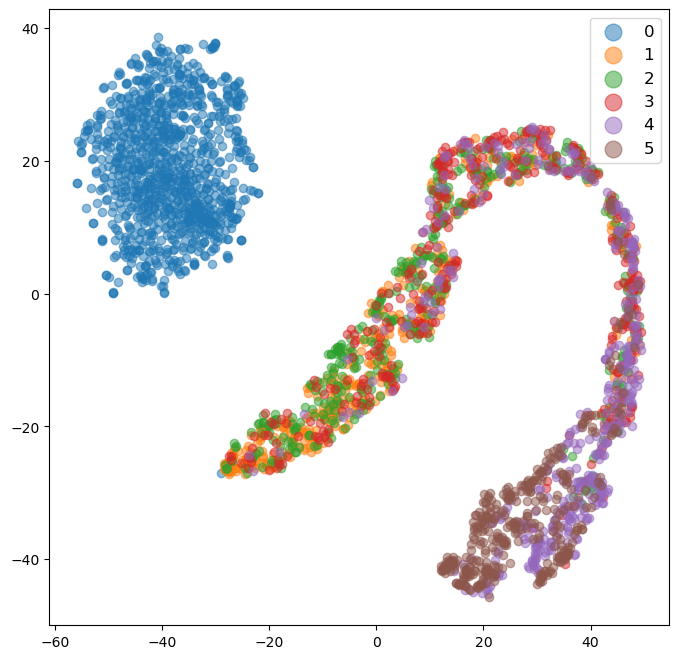

In [90]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=2000, init='random', perplexity=40, early_exaggeration=50, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

# Plot the similarity comparison

In [80]:
data_dir = '/mnt/c/Users/PCM/Dropbox/chla_fundus_croped/severity'
datalne = {'train':1000, 'val':1, 'test':1000}
image_datasets = {x: PapilSeverityDataset(data_dir=data_dir, phase=x, datalen=datalne[x], mode="binary_contrastive") for x in ['train', 'val', 'test']}
batch_size = {'train':1, 'val':16, 'test':1}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x], shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val',  'test']}
class_names = ['0','1']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device, class_names)

cuda:0 ['0', '1']


In [81]:
bestsimese50simclr = SiameseNetwork101().to(device)
state_dict = torch.load('./pretrained/best-contrastive50-2024-02-25.pt')
bestsimese50simclr.load_state_dict(state_dict)

<All keys matched successfully>

In [82]:
test_acc = 0
test_embeddings = torch.zeros((0, 256))
test_targets = []

for inputs, labels, args in dataloaders['train']:
        bestsimese50simclr.eval()
        inputA = inputs[0].to(device)
        inputB = inputs[1].to(device)
        labels = labels.to(device)

        with torch.no_grad():
            output1, output2 = bestsimese50simclr(inputA, inputB)
            preds = (torch.max(output1, 1)[1] == torch.max(output2, 1)[1])*1
            # loss = loss_fn(inputA, inputB, labels)
            # test_acc += torch.sum(preds == labels.data)
            test_targets.append(args[0])
            test_targets.append(args[1])
            test_embeddings  = torch.cat((test_embeddings, output1.detach().cpu().flatten().unsqueeze(0)), axis=0)
            test_embeddings  = torch.cat((test_embeddings, output2.detach().cpu().flatten().unsqueeze(0)), axis=0)
# test_acc

test_targets = torch.stack(test_targets).flatten()
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002148
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.336250
[t-SNE] KL divergence after 1000 iterations: 2.532073


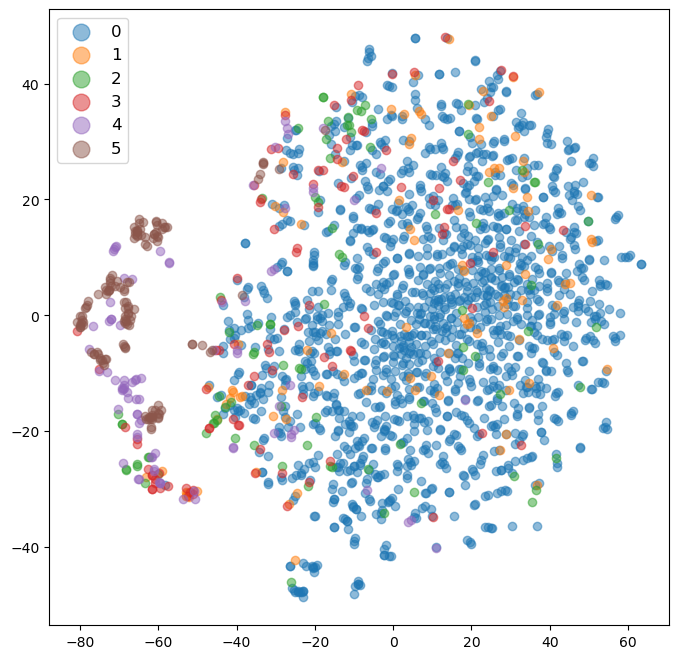

In [83]:
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
embeddings = test_embeddings[~np.isnan(test_targets)]
targets = test_targets[~np.isnan(test_targets)]

tsne = TSNE(2, verbose=1, n_iter=1000, init='random', perplexity=10, early_exaggeration=12, metric="cosine")
tsne_proj = tsne.fit_transform(embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 6
for lab in range(num_categories):
    indices = targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()